In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sindy_utils import sindy_library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from scipy.integrate import odeint

In [3]:
def rossler(X, t, a=0.15, b=0.2, c=10):
    x, y, z = X
    return -y-z, x+a*y, b+z*(x-c)

def build_hankel_matrix(x, delay=30):
    N = len(x)
    M = N - delay - 1
    hankel = np.zeros((delay, M))
    for i in range(delay):
        hankel[i, :] = x[i:i+M]
    return hankel

def generate_time_series(func, x0, t, args=()):
    return odeint(func, x0, t).T

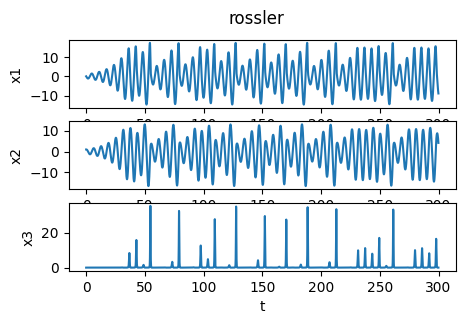

In [4]:
x0 = [0, 1, 0]
ndt = 1 # n*dt is roughly the period of oscillation
num_step_per_period = 13 # number of time steps per period
periods = 300 # number of periods to simulate
t = np.linspace(0, int(periods*ndt), int(periods*num_step_per_period), endpoint=False)
arg = ()

# SINDy parameters
plot_systems = True
poly_order = 3
nd = 3
delay = num_step_per_period
alpha = 0.4
project = False

usesine = False

# Training parameters
test_size = 0.2
random_state = 0

# Plot systems and their corresponding time series 
if plot_systems:
        X = generate_time_series(rossler, x0, t, arg)
        # plot time series
        fig, ax = plt.subplots(len(x0), 1, figsize=(5, 3))
        for j in range(len(x0)):
            ax[j].plot(t, X[j, :])
            ax[j].set_xlabel('t')
            ax[j].set_ylabel('x{}'.format(j+1))
        plt.suptitle(rossler.__name__)
        plt.show()

In [5]:
# 1. Loop through dynamical systems models,
# 2. generate time series, and build hankel matrices
# 3. for each time series apply SVD to get the basis vectors (k rows of VT)
# 4. Then build a polynomial library in VT_k 
# 5. Train a linear model to fit the library to the original full-state time series


# Loop through dynamical systems
results = []

x = generate_time_series(rossler, x0, t, arg)

# project on random vector
if project:
    n = np.random.randn(x.shape[0])
    n = n/np.linalg.norm(n)
    xp = np.sum(x * n[:, None], axis=0)
else:
    xp = x[0, :]
    n = None

# Build hankel matrix
H = build_hankel_matrix(xp, delay)

# SVD
U, s, VT = np.linalg.svd(H, full_matrices=False)

v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))

# Build polynomial library Assuming nd dominant modes
X, names = sindy_library(v, poly_order, include_names=True, include_sine=False)


# Split data into training and testing sets
x_train, x_test, library_train, library_test = train_test_split(x[:, :X.shape[0]].T, X, 
                                            test_size=test_size, random_state=random_state,
                                            shuffle=False)


# Train linear model
model = Lasso(alpha=alpha, fit_intercept=False, max_iter=50000)
model.fit(library_train, x_train)
# print(model.coef_)

# Evaluate model
x_pred = model.predict(library_test)

# Compute error
error = np.linalg.norm(x_pred - x_test)/np.linalg.norm(x_test)
score = model.score(library_test, x_test)
num_zeros = np.sum(model.coef_ == 0.0)


print("Error: %f" % error)
print("Score: %f" % score)

print('sparsity : ', num_zeros/(np.prod(model.coef_.shape)))
print('----')

# Store results in list
results.append((rossler.__name__, x_train, x_test, x_pred, 
    library_train, library_test, model, error, score, names, model.coef_, v, n))


Error: 0.092653
Score: 0.967600
sparsity :  0.2833333333333333
----


(3900,)
(3, 3900)


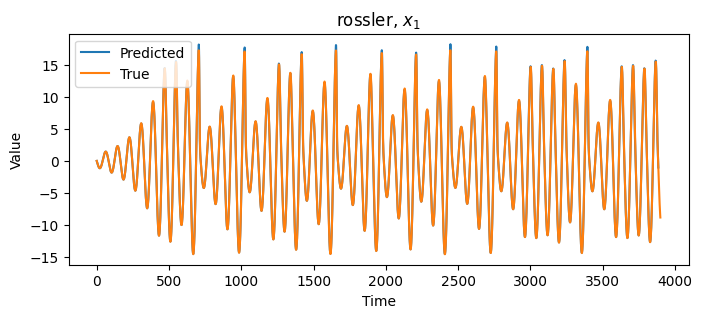

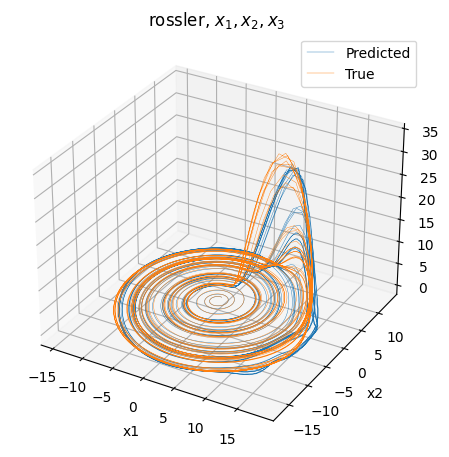

In [9]:

# import numpy as np
# Plot results till time 10
iend = 50000 
# Plot results
fig1, axes = plt.subplots(1, 1, figsize=(8, 3))
fig2 = plt.figure(figsize=(13, 13))

ax3d = fig2.add_subplot(1, 3, 1, projection='3d')

nper = 1.0
t = np.linspace(0, int(nper*periods*ndt), int(nper*periods*num_step_per_period), endpoint=False)
x = generate_time_series(rossler, x0, t, arg)

if project:
    xp = np.sum(x * n[:, None], axis=0)
else:
    xp = x[0, :]

H = build_hankel_matrix(xp, delay)
U, s, VT = np.linalg.svd(H, full_matrices=False)
v = np.matmul(VT[:nd, :].T, np.diag(s[:nd]))
X, names = sindy_library(v, poly_order, include_names=True, include_sine=False)
x_pred = model.predict(X).T

# print(model.coef_)
print(x.shape)

axes.plot(x_pred[0, :iend], label='Predicted')
axes.plot(x[0, :iend], label='True')
axes.set_title("%s, $x_%d$" % (rossler.__name__, 1))
axes.set_xlabel("Time")
axes.set_ylabel("Value")
axes.legend()
    
ax3d.plot(x_pred[0, :iend], x_pred[1, :iend], x_pred[2, :iend], lw=.3,label='Predicted')
ax3d.plot(x[0, :iend], x[1, :iend], x[2, :iend], lw=.3,label='True')
ax3d.set_title("%s, $x_1, x_2, x_3$" % (rossler.__name__))
ax3d.set_xlabel("x1")
ax3d.set_ylabel("x2")
ax3d.set_zlabel("x3")
ax3d.legend()
plt.tight_layout()
plt.show()